# Metric Learning Baseline
事前学習モデルの最終層の出力(Global Pooling)を類似度検索のベクトルに利用

In [186]:
import os

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import timm
import albumentations as A
import cv2

import umap
import seaborn as sns

## 利用データ

In [187]:
!ls ../tmp/market_metriclearning_HT

images    test.csv  train.csv


In [188]:
!ls -l ../tmp/market_metriclearning_HT/images | wc -l

   12937


In [189]:
image_dir = '../tmp/market_metriclearning_HT/images'

In [190]:
df_train = pd.read_csv('../tmp/market_metriclearning_HT/train.csv')
print(df_train.shape)
df_train.head()

(12114, 3)


,image_id,label,fold
0,0517_c5s1_143520_02.jpg,517,2
1,0816_c6s2_104418_01.jpg,816,4
2,1278_c1s6_012016_02.jpg,1278,2
3,0508_c5s2_082302_02.jpg,508,1
4,1198_c6s3_034292_01.jpg,1198,3


In [191]:
df_train['image_id'].nunique()

11673

In [192]:
df_train['label'].value_counts()[200:220]

label
358     20
175     20
665     20
1385    20
394     20
499     20
806     20
681     20
754     20
204     20
508     20
1081    20
1269    20
700     20
32      20
905     20
1275    20
1176    20
630     20
1443    20
Name: count, dtype: int64

In [193]:
# 上記20ラベル分のデータに絞る
df_sample = df_train[df_train['label'].isin(df_train['label'].value_counts()[200:220].index)]
df_sample

,image_id,label,fold
3,0508_c5s2_082302_02.jpg,508,1
25,0358_c3s1_082117_05.jpg,358,4
38,0665_c1s3_061901_01.jpg,665,0
43,0681_c5s2_054730_02.jpg,681,2
70,0508_c2s2_078882_02.jpg,508,4
...,...,...,...
12041,0905_c6s3_021567_01.jpg,905,3
12075,0175_c4s1_031976_01.jpg,175,3
12097,0175_c1s1_031226_02.jpg,175,1
12098,0394_c3s1_094192_01.jpg,394,1


In [194]:
'''
df_test = pd.read_csv('../tmp/market_metriclearning_HT/test.csv')
print(df_test.shape)
df_test.head()
'''

"\ndf_test = pd.read_csv('../tmp/market_metriclearning_HT/test.csv')\nprint(df_test.shape)\ndf_test.head()\n"

In [195]:
img_size = 128
batch_size = 64

dataframe_image_col = 'image_id'
dataframe_label_col = 'label'

In [196]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Augmentation, Dataset

In [197]:
transform_scoring = A.Compose([
    A.Resize(height=img_size, width=img_size, p=1),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [198]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, img_dir, transforms, mode='train'):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        img_file_name = self.df.loc[index, dataframe_image_col]
        img_file_path = os.path.join(self.img_dir, img_file_name)
        target = self.df.loc[index, dataframe_label_col]
    
        image = cv2.imread(img_file_path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        image_transformed = self.transforms(image=image)['image']

        image_transformed = image_transformed.astype(np.float32)
        image_transformed = image_transformed.transpose(2, 0, 1)
        #image_transformed /= 255.   # transform内で正規化するので実施なし

        if self.mode == 'inference':
            return torch.tensor(image_transformed).float()
        else:   # Train/Valid/Testなど正解ラベルが必要な時
            return torch.tensor(image_transformed).float(), torch.tensor(target).long()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<__main__.CustomDataset object at 0x7fa8c2b0a430> 400
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([3, 128, 128]) tensor(1269)


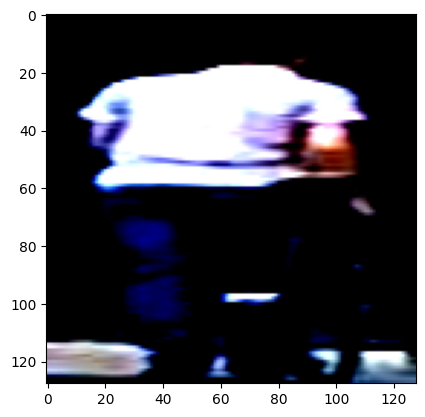

In [199]:
# Dataset test
tmp_dataset = CustomDataset(df=df_sample, img_dir=image_dir, transforms=transform_scoring, mode='train')
print(tmp_dataset, len(tmp_dataset))

tmp_img, tmp_label = tmp_dataset[123]    # 表示画像indexを指定
print(type(tmp_img), type(tmp_label))
print(tmp_img.shape, tmp_label)

plt.imshow(tmp_img.permute(1, 2, 0))
plt.show()

## Model

In [200]:
# デフォルトで読み込み
backborn = timm.create_model('resnet50', pretrained=True)
backborn.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth',
 'hf_hub_id': 'timm/resnet50.a1_in1k',
 'architecture': 'resnet50',
 'tag': 'a1_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models',
 'paper_ids': 'arXiv:2110.00476'}

In [201]:
# output test
backborn(torch.rand(8, 3, 328, 328)).shape

torch.Size([8, 1000])

In [202]:
# 各畳み込み層の出力を取得する場合
backborn = timm.create_model('resnet50', pretrained=True, features_only=True)
backborn.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth',
 'hf_hub_id': 'timm/resnet50.a1_in1k',
 'architecture': 'resnet50',
 'tag': 'a1_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'pool_size': (7, 7),
 'first_conv': 'conv1',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models',
 'paper_ids': 'arXiv:2110.00476'}

In [203]:
# output test
sample_in = torch.rand(8, 3, 328, 328)

sample_out = backborn(sample_in)
print(len(sample_out))
print(sample_out[0].shape)
print(sample_out[1].shape)
print(sample_out[2].shape)
print(sample_out[3].shape)
print(sample_out[4].shape)    # 最後の畳み込み層の出力

5
torch.Size([8, 64, 164, 164])
torch.Size([8, 256, 82, 82])
torch.Size([8, 512, 41, 41])
torch.Size([8, 1024, 21, 21])
torch.Size([8, 2048, 11, 11])


#### 事前学習済みモデルのGlobal Poolingの出力を利用

In [204]:
# Head部分なしでのモデル取得（Global Poolingの出力）
backborn = timm.create_model('resnet50', pretrained=True, num_classes=0)
backborn.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth',
 'hf_hub_id': 'timm/resnet50.a1_in1k',
 'architecture': 'resnet50',
 'tag': 'a1_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models',
 'paper_ids': 'arXiv:2110.00476'}

In [205]:
backborn(torch.rand(8, 3, 328, 328)).shape
# 2028元のベクトルが出力（Resnet18だと512次元）

torch.Size([8, 2048])

## 推論

In [206]:
dataset_train = CustomDataset(df=df_sample, img_dir=image_dir, transforms=transform_scoring, mode='train')
print(dataset_train)
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
print(loader_train)

In [207]:
OUTPUTS, TARGETS = [], []
bar = tqdm(loader_train)
backborn = backborn.to(device)
backborn.eval()

with torch.no_grad():
        for i, (images, targets) in enumerate(bar):    # バッチループ
            images = images.to(device)
            targets = targets.to(device)
            outputs = backborn(images)
            
            OUTPUTS.append(outputs.cpu().numpy())
            TARGETS.append(targets.cpu().numpy())

OUTPUTS = np.concatenate(OUTPUTS)
TARGETS = np.concatenate(TARGETS)

  0%|          | 0/7 [00:00<?, ?it/s]

In [208]:
OUTPUTS.shape, TARGETS.shape

((400, 2048), (400,))

In [209]:
df_sample_res = df_sample.copy()
df_sample_res['img_vec'] = [v for v in OUTPUTS]
#df_sample_res['target'] =  = [t for t in TARGETS]    # TARGETSはdf_sample['label']と同じ

In [210]:
df_sample_res = df_sample_res.sort_values('label')
df_sample_res = df_sample_res.reset_index(drop=True)
df_sample_res

,image_id,label,fold,img_vec
0,0032_c6s1_003051_02.jpg,32,4,"[0.0, 0.0017174743, 0.0, 0.0, 0.22696367, 0.0,..."
1,0032_c3s1_002526_02.jpg,32,1,"[0.12436622, 0.0, 0.0, 0.0, 1.7960243, 0.0, 0...."
2,0032_c3s1_002276_01.jpg,32,3,"[0.0, 0.0, 0.0, 0.0, 0.49914616, 0.0, 0.001184..."
3,0032_c3s1_002451_02.jpg,32,4,"[0.0, 0.038806118, 0.032832358, 0.045347687, 0..."
4,0032_c5s1_002851_02.jpg,32,3,"[0.0, 0.0, 0.009126648, 0.0, 0.4315549, 0.0, 0..."
...,...,...,...,...
395,1443_c6s3_080892_01.jpg,1443,2,"[0.0, 0.0, 0.0, 0.077248394, 0.28308335, 0.0, ..."
396,1443_c3s3_068594_03.jpg,1443,0,"[0.0, 0.0, 0.0, 0.0, 1.4951522, 0.013127595, 0..."
397,1443_c3s3_068619_02.jpg,1443,2,"[0.0, 0.015799671, 0.0024591386, 0.0, 0.420826..."
398,1443_c3s3_057153_02.jpg,1443,1,"[0.0, 0.0091415215, 0.0, 0.01873561, 0.4178419..."


In [211]:
type(df_sample_res.loc[0, 'img_vec'])

numpy.ndarray

In [212]:
#df_sample_res['label'].value_counts()

## 可視化（UMAP）

UMAP
- https://github.com/lmcinnes/umap
- https://umap-learn.readthedocs.io/en/latest/index.html

/opt/anaconda3/envs/PyTorch/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


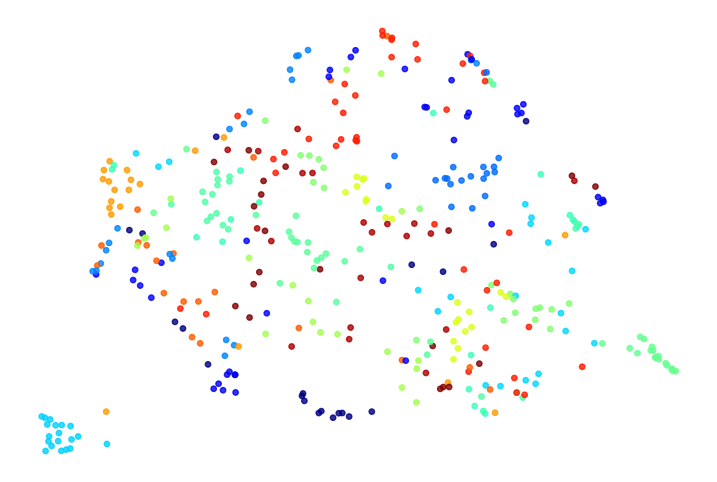

In [213]:
mapper = umap.UMAP(random_state=0)
embedding = mapper.fit_transform(OUTPUTS)

import matplotlib.pyplot as plt 
plt.figure(figsize=(9, 6))
plt.scatter(embedding[:, 0], embedding[:, 1],
            #c=[sns.color_palette()[x] for x in range(len(np.unique(TARGETS)))], 
            c=TARGETS,
            cmap='jet',
            s=15, 
            alpha=0.8)
plt.axis('off')
#plt.colorbar()
plt.show()

## 画像間類似度と画像の表示

In [99]:
df_sample_res

,image_id,label,fold,img_vec
0,0032_c6s1_003051_02.jpg,32,4,"[0.0, 0.0010196529, 0.0, 0.0, 0.2188478, 0.0, ..."
1,0032_c3s1_002526_02.jpg,32,1,"[0.12894368, 0.0, 0.0, 0.0, 1.7495695, 0.0, 0...."
2,0032_c3s1_002276_01.jpg,32,3,"[0.0, 0.0, 0.0, 0.0, 0.47321796, 0.0, 0.001789..."
3,0032_c3s1_002451_02.jpg,32,4,"[0.0, 0.036019325, 0.03121851, 0.044259552, 0...."
4,0032_c5s1_002851_02.jpg,32,3,"[0.0, 0.0, 0.007636659, 0.0, 0.40710688, 0.0, ..."
...,...,...,...,...
395,1443_c6s3_080892_01.jpg,1443,2,"[0.0, 0.0, 0.0, 0.07733506, 0.2656164, 0.0, 0...."
396,1443_c3s3_068594_03.jpg,1443,0,"[0.0, 0.0, 0.0, 0.0, 1.4448318, 0.013492249, 0..."
397,1443_c3s3_068619_02.jpg,1443,2,"[0.0, 0.019452263, 0.0011229254, 0.0, 0.396367..."
398,1443_c3s3_057153_02.jpg,1443,1,"[0.0, 0.009343207, 0.0, 0.015976764, 0.4105655..."


In [82]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [83]:
# 同じラベル間の類似度
cos_sim(df_sample_res.loc[0,'img_vec'], df_sample_res.loc[1,'img_vec'])

0.6042266

In [92]:
# 同じ画像の類似度
cos_sim(df_sample_res.loc[0,'img_vec'], df_sample_res.loc[0,'img_vec'])

0.9999999

In [93]:
# 異なったラベル間の類似度
cos_sim(df_sample_res.loc[0,'img_vec'], df_sample_res.loc[399,'img_vec'])

0.5132705

In [101]:
# ラベルのリスト
df_sample_res['label'].unique()

array([  32,  175,  204,  358,  394,  499,  508,  630,  665,  681,  700,
        754,  806,  905, 1081, 1176, 1269, 1275, 1385, 1443])

In [180]:
def similar_images(idx, top_k=10):
    ''' 指定したインデックスと類似した画像の検索とそれらの表示
    top_k: 上位k個の類似画像
    '''
    label = df_sample_res.loc[idx, 'label']
    print(f'Data Index: {idx}, Label: {label}')
    base_vac = df_sample_res.loc[idx,'img_vec']

    f = lambda x: cos_sim(base_vac, x)
    similarity = df_sample_res['img_vec'].apply(f)

    tmp_d = df_sample_res[['image_id','label',]].copy()
    tmp_d['similarity'] = similarity
    top_k_df = tmp_d.sort_values('similarity', ascending=False)[:top_k].reset_index(drop=True)
    display(top_k_df)
    n_same_label = sum(top_k_df['label']==label)   # top_k中、指定した画像と同じラベルの数
    print(f'Out of top {top_k}, {n_same_label} is the same label group.')
    
    
    ### プロット
    top_k_df =  top_k_df[:10]   # 10画像のみ表示
    fig = plt.figure(figsize=(60, 10))
    counter = 1
    for i, row in top_k_df.iterrows():
        im_id = row['image_id']
        im_path = os.path.join(image_dir, im_id)
        lb = row['label']
        sim = row['similarity']
        
        ax = fig.add_subplot(1, 10, counter)
        if i==0:
            title = f'Your img - ID:{lb}'
        else:
            title = f'ID:{lb}, Sim:{sim:.3f}'
        ax.set_title(title, fontsize=30)
        im = cv2.imread(im_path)
        converted_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        plt.imshow(converted_im)
        counter = counter + 1
    
    return None

Data Index: 0, Label: 32


,image_id,label,similarity
0,0032_c6s1_003051_02.jpg,32,1.000000
1,0032_c6s1_003026_02.jpg,32,0.801436
2,0032_c6s1_002926_02.jpg,32,0.784243
3,0032_c6s1_002951_03.jpg,32,0.763624
4,0032_c6s1_002976_02.jpg,32,0.758073
5,1176_c6s3_042517_02.jpg,1176,0.751838
6,0032_c6s1_002901_02.jpg,32,0.739589
7,0806_c6s2_089018_02.jpg,806,0.727700
8,0032_c6s1_002926_04.jpg,32,0.726744
9,0032_c6s1_003001_02.jpg,32,0.726719


Out of top 10, 8 is the same label group.


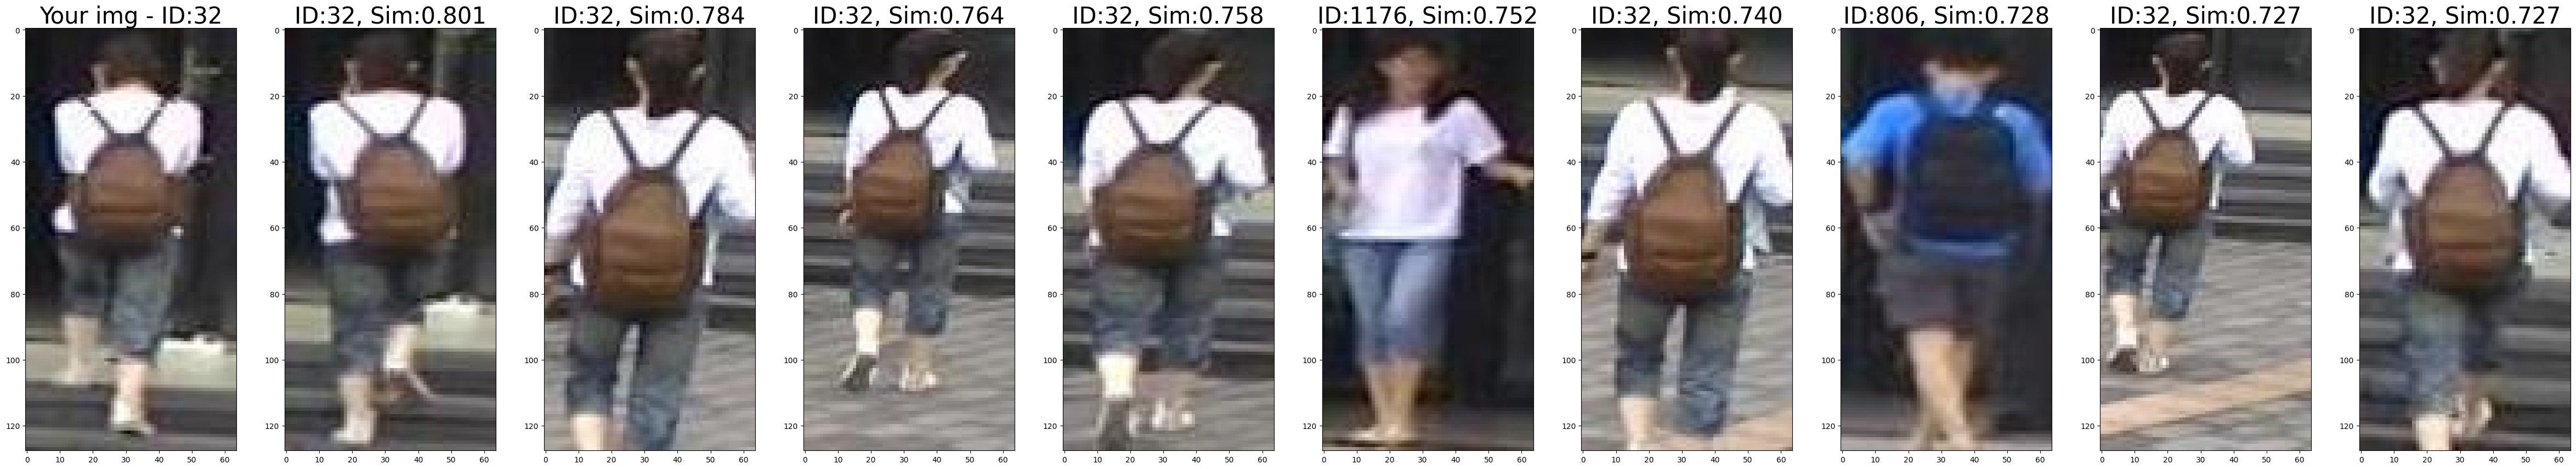

In [181]:
similar_images(idx=0)

Data Index: 99, Label: 394


,image_id,label,similarity
0,0394_c3s1_093042_02.jpg,394,1.000000
1,0394_c3s1_093042_02.jpg,394,1.000000
2,0204_c3s1_076217_03.jpg,204,0.848241
3,0032_c3s1_002401_02.jpg,32,0.831134
4,0204_c3s1_076192_04.jpg,204,0.830931
5,1176_c5s3_019590_02.jpg,1176,0.829305
6,1176_c4s5_032554_03.jpg,1176,0.827732
7,1176_c5s3_007143_03.jpg,1176,0.821754
8,0394_c5s1_093523_07.jpg,394,0.818772
9,1176_c4s5_045560_03.jpg,1176,0.816339


Out of top 10, 3 is the same label group.


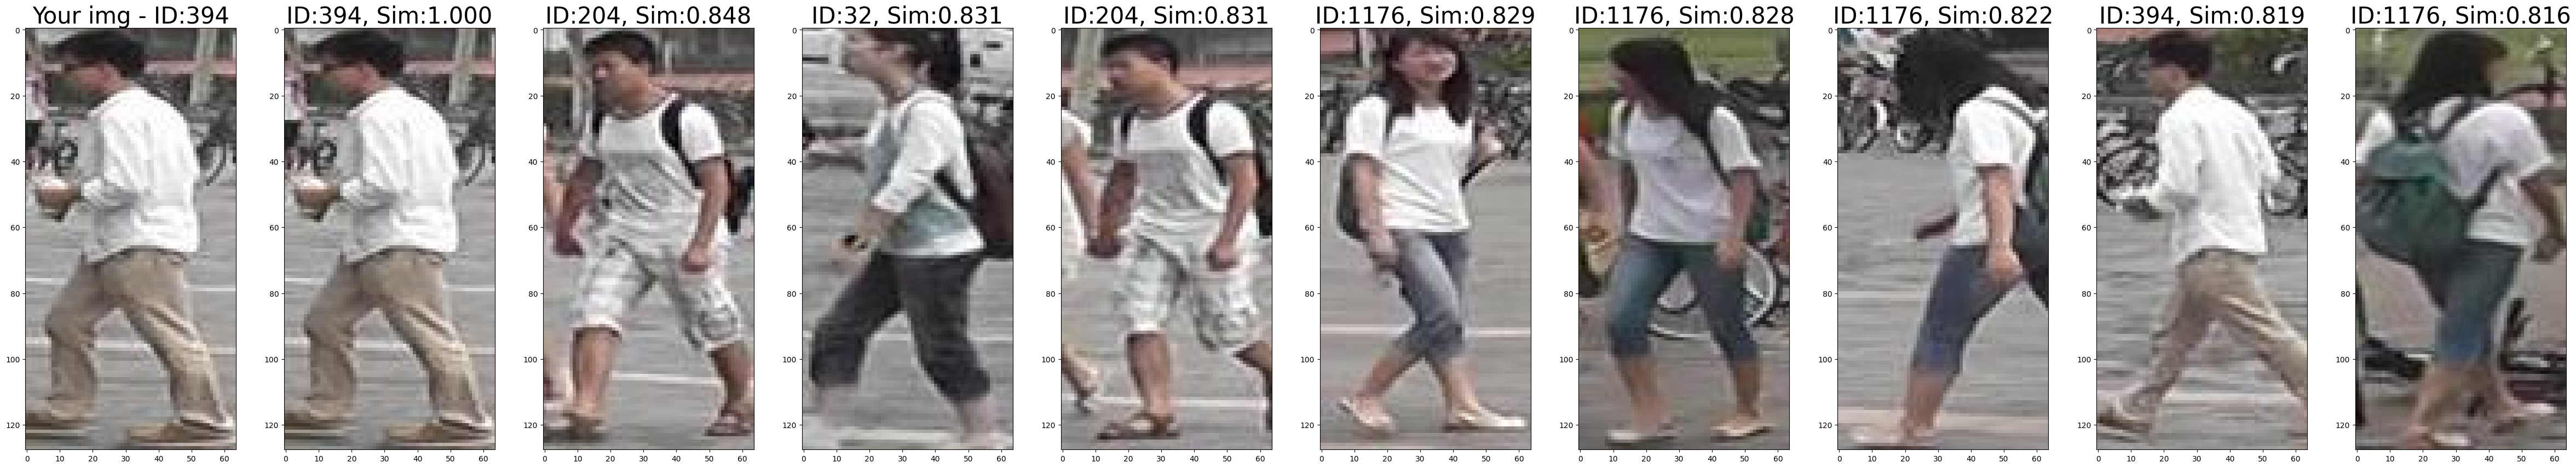

In [182]:
similar_images(idx=99)

Data Index: 250, Label: 806


,image_id,label,similarity
0,0806_c6s2_088893_03.jpg,806,1.000000
1,0806_c6s2_088968_02.jpg,806,0.753998
2,0806_c6s2_088918_02.jpg,806,0.752459
3,1443_c3s3_068619_02.jpg,1443,0.737933
4,0394_c3s1_093092_02.jpg,394,0.736509
5,0806_c6s2_089018_02.jpg,806,0.734598
6,0806_c6s2_089043_02.jpg,806,0.727504
7,0630_c2s2_020937_05.jpg,630,0.722287
8,1176_c6s3_030492_02.jpg,1176,0.718844
9,0806_c5s2_105902_01.jpg,806,0.718332


Out of top 10, 6 is the same label group.


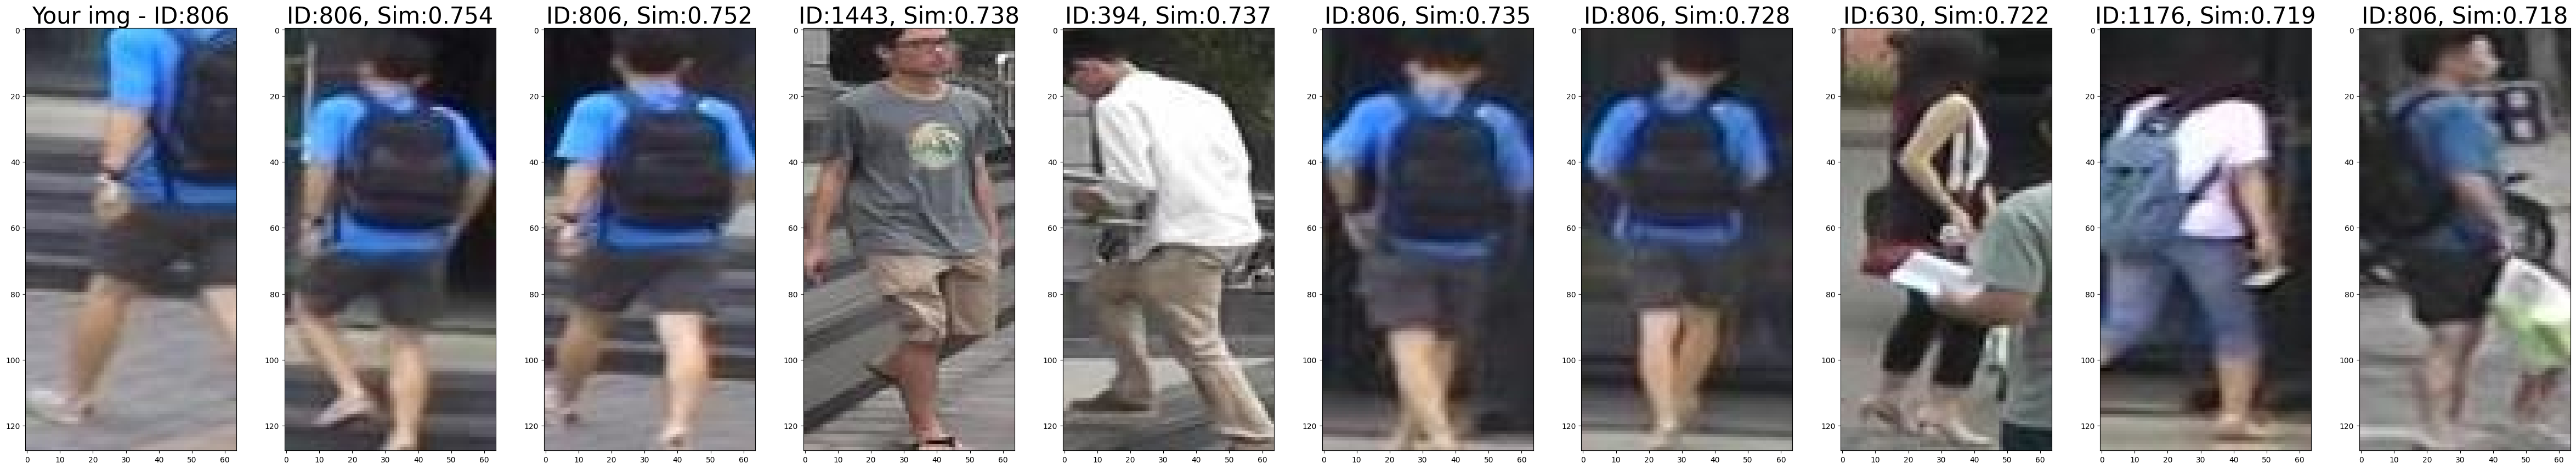

In [183]:
similar_images(idx=250)

Data Index: 320, Label: 1269


,image_id,label,similarity
0,1269_c1s5_071391_01.jpg,1269,1.000000
1,1269_c4s5_071435_01.jpg,1269,0.748428
2,1269_c4s5_050810_03.jpg,1269,0.719385
3,1269_c3s3_024903_04.jpg,1269,0.672545
4,0175_c4s5_013779_10.jpg,175,0.670506
5,0358_c2s1_081796_03.jpg,358,0.656760
6,1269_c4s5_050760_01.jpg,1269,0.652261
7,1269_c1s5_051166_01.jpg,1269,0.647368
8,1269_c3s3_025053_04.jpg,1269,0.643926
9,0175_c4s5_016004_04.jpg,175,0.633141


Out of top 10, 7 is the same label group.


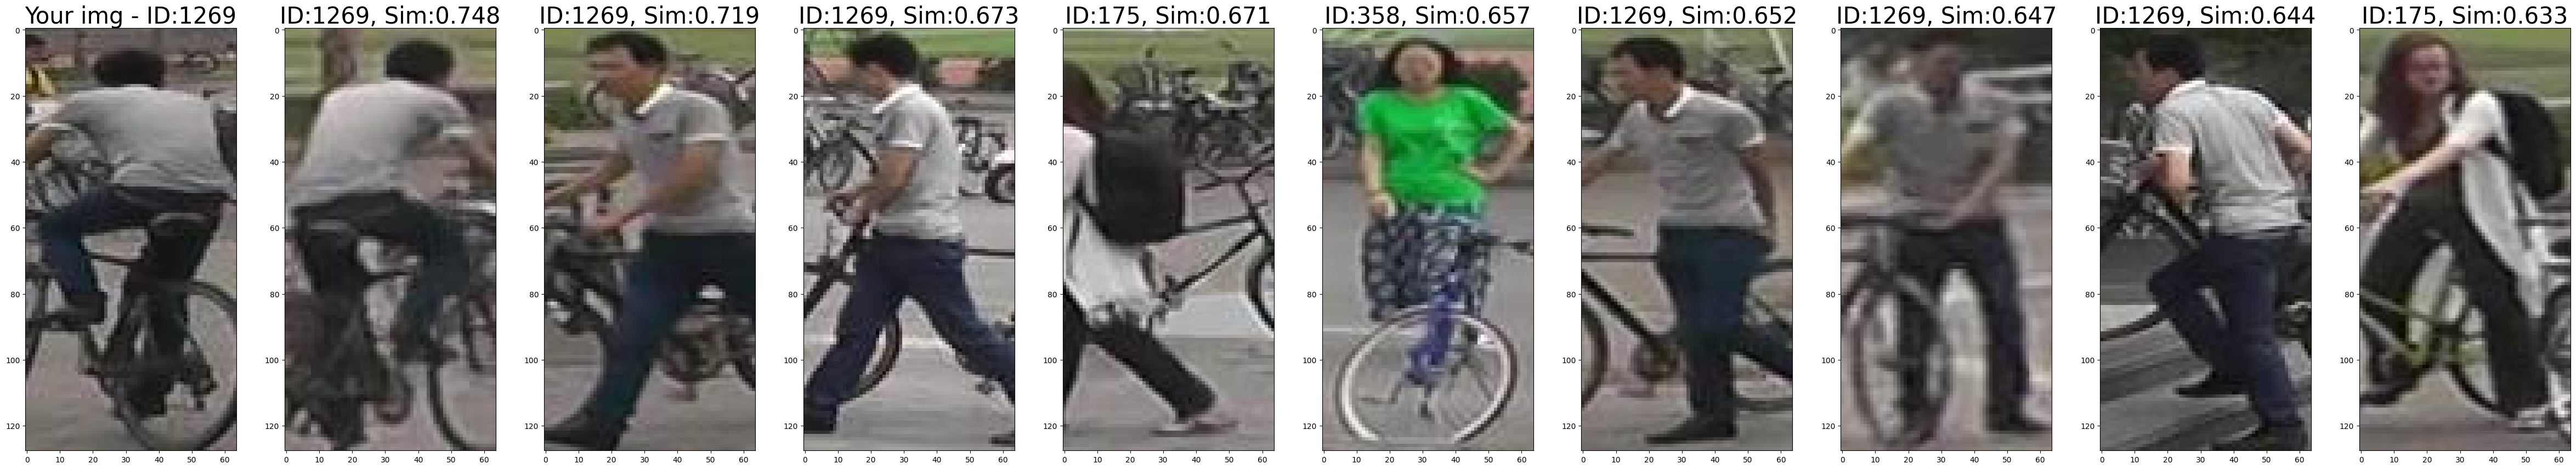

In [184]:
similar_images(idx=320)

Data Index: 390, Label: 1443


,image_id,label,similarity
0,1443_c2s3_050807_04.jpg,1443,1.000000
1,1443_c2s3_050832_04.jpg,1443,0.853399
2,1385_c3s3_075919_01.jpg,1385,0.801956
3,1176_c5s3_019590_02.jpg,1176,0.788835
4,0032_c3s1_002401_02.jpg,32,0.787120
5,1443_c5s3_069337_03.jpg,1443,0.772313
6,1443_c3s3_057153_02.jpg,1443,0.772156
7,1275_c1s5_059516_02.jpg,1275,0.768388
8,0681_c5s2_054830_02.jpg,681,0.767834
9,1443_c3s3_068619_02.jpg,1443,0.767214


Out of top 10, 5 is the same label group.


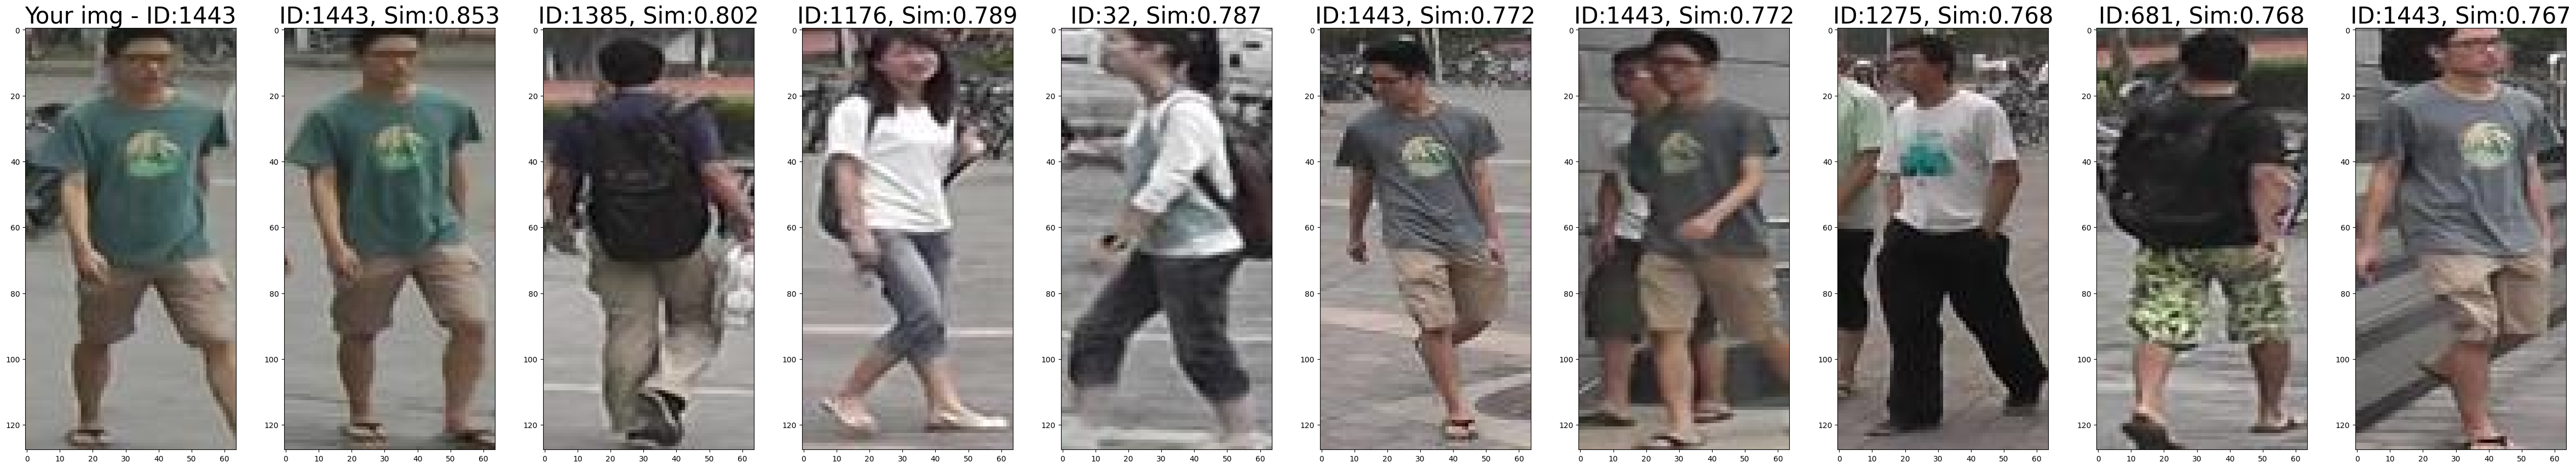

In [185]:
similar_images(idx=390)